In [1]:
# Three helpers functions are used to preprocess the dataset, plot diagrams and to perform wavelet packet decompositions
# please check them under the helpers folder
from helpers.DatasetProcess import dataset_to_df
from helpers.PlotExtension import norm_to_plot, img_plot
from helpers.WaveletPacket import wpt_dec, plot_wpt_nodes, plot_wpt_fun, wavelet_families, get_maxlevel

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn

# Pytorch is used to build the model
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn import CrossEntropyLoss

from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau , CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops.layers.torch import Rearrange
from einops import rearrange, repeat

from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, recall_score, f1_score

In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

(7444889600, 8589410304)

### First: Load the Dataset and Get Some Statistics

In [4]:
dataset_name = "CIFAKE"
path = '../../data/CIFAKE'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
original_split = ["train", "train", "test", "test"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

re_split = False

# re-split determines whether to split the dataset into train , valid and test based on desired ratios
# if re-split is set to false , then dataset will be taken as is based on it's original splits and the below ratios
# will be ignored. Otherwise if re_split is set to True , then you can decide the split ratios as follows:
train_ratio = 0.8
valid_ratio = 0.14
test_ratio = 1-(train_ratio+valid_ratio)

if re_split:
    print(f'({train_ratio},{valid_ratio},{1-train_ratio-valid_ratio})')
else:
    print('Using the original dataset splits without change')

Using the original dataset splits without change


In [5]:
classes = list(set(paths_classes))
classes.sort()
print(f'Classes:{classes}')

Classes:['FAKE', 'REAL']


In [6]:
try:
    df_all = pd.read_csv(f'{path}/df_all.csv')
    df_train = pd.read_csv(f'{path}/df_train.csv')
    df_val = pd.read_csv(f'{path}/df_val.csv')
    df_test = pd.read_csv(f'{path}/df_test.csv')
    classes_stats = pd.read_csv(f'{path}/classes_stats.csv')
except FileNotFoundError:
    df_all, df_train, df_val, df_test, classes_stats = dataset_to_df( path, relative_paths, paths_classes, original_split, re_split, train_ratio, valid_ratio, test_ratio)
    df_all.to_csv(f'{path}/df_all.csv', index=False)
    df_train.to_csv(f'{path}/df_train.csv', index=False)
    df_val.to_csv(f'{path}/df_val.csv', index=False)
    df_test.to_csv(f'{path}/df_test.csv', index=False)
    classes_stats.to_csv(f'{path}/classes_stats.csv')

classes_stats

,Unnamed: 0,REAL,FAKE,Total
0,Training,50000,50000,100000
1,Validation,10000,10000,20000
2,Testing,10000,10000,20000
3,Row_Total,70000,70000,140000


In [7]:
df_test.iloc[[0, -1]]

,Image_path,Height,Width,Channels,Class,Class_Codes,Class_Onehot
0,../../data/CIFAKE//test/REAL/0686(5).jpg,32,32,RGB,REAL,1,[1 0]
19999,../../data/CIFAKE//test/FAKE/495.jpg,32,32,RGB,FAKE,0,[0 1]


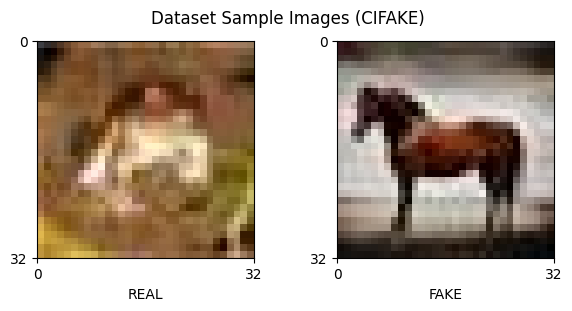

In [8]:
r_img_idx, f_img_idx = 6, -3
step = 32


fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(6, 3))
fig.suptitle(f'Dataset Sample Images ({dataset_name})')

r_img = read_image(df_all.iloc[r_img_idx, 0])
f_img = read_image(df_all.iloc[f_img_idx, 0])

n = r_img.shape[1]
extent = [0, n, n, 0]

axs[0].imshow(r_img.permute(1, 2, 0), extent=extent)
axs[0].set(xlabel=df_all.iloc[r_img_idx, 4])
axs[0].set(xticks=np.arange(0, r_img.shape[2]+1, step=step),
           yticks=np.arange(0, r_img.shape[1]+1, step=step))

axs[1].imshow(f_img.permute(1, 2, 0), extent=extent)
axs[1].set(xlabel=df_all.iloc[f_img_idx, 4])
axs[1].set(xticks=np.arange(0, f_img.shape[2]+1, step=step),
           yticks=np.arange(0, f_img.shape[1]+1, step=step))

plt.show()

### Second: Define the Hyper Parameters of the Model

In [9]:
n_extra_epochs = 200

use_scheduler = False
continue_lr = False

start_from_model = False
max_epochs = None #300
# If start_from_model is True, then load a pretrained model and continue training after the model last epoch
# Training will continue until reach to max_epochs (integer number)
# if max_epochs = None ==> there will be no upper limit for last epoch 

In [10]:
# Define the Path of the Model
model_type = "vit"
weights_folder_path = "../weights"
model_folder = "CIFAKE"

checkpoint_folder = "WPT-ViT_db2_L3_P1_H18_E2_S0_B1000_D32_CIFAKE"


# now put a label for the saved model
model_code = checkpoint_folder.split("_")[0]+"_"+checkpoint_folder.split("_")[1]+"_"+''.join(checkpoint_folder.split("_")[2:9])+"_"+checkpoint_folder.split("_")[9]

print(model_code)

# The above Folder name reflects the key model hyper parameters, as follows:

# Model Type: (e.g. VITWPT)
# wavelet_fun : Name of the wavelet function (e.g. db2)
# wavelet_level(L) : The maximum level to which image will be decomposed (e.g. L3)
# Patches per decomposition(P): Number of patches (slices) per each WPT decomposition (e.g. P1)
# Heads(H): Number of heads of the transformer (e.g. H36)
# encoder_levels : Number of stacked encoders (e.g. E1)
# Sliced? (S: Whether we are using a subset of the WPT decompositions (True:1 , False:0) (e.g. S0)
# Batch_size(B): Batch Size that fed to the model.
# Dimension(D): The Dimension of the Dataset after (resize) (e.g. D32)
# Dataset: Name of the Dataset (e.g. CIFAKE)

WPT-ViT_db2_L3P1H18E2S0B1000D32_CIFAKE


In [11]:
# file name of the saved model
if start_from_model:
    model_file_name = f"WPT-ViT_db2_L3P1H18E2S0B1000D32_CIFAKE_ph1_ep195_acc92.69"

In [12]:
model_state_path = f"{weights_folder_path}/{model_folder}/{checkpoint_folder}/"

if start_from_model:
    checkpoint = torch.load(model_state_path+model_file_name)

In [13]:
start_epoch = checkpoint['epoch_lst'][-1] if start_from_model else 0
end_epoch = start_epoch + n_extra_epochs if max_epochs == None else max_epochs
delta_epochs = end_epoch-start_epoch

print(f"Train another {delta_epochs} epochs after epoch {start_epoch} ")

Train another 200 epochs after epoch 0 


In [14]:
if start_from_model:
    training_phase_lst = checkpoint['training_phase_lst']
    training_phase = training_phase_lst[-1]+1
else: 
    training_phase = 1

print(training_phase)

1


In [15]:
wavelet_families()

0) haar: haar
1) db: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
2) sym: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
3) coif: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
4) bior: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
5) rbio: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
6) dmey: dmey
 



In [16]:
# Wavelet Packet Transform Hyper Parameters
wpt_fun = 'db2'
wpt_level = 3
wpt_mode = 'symmetric'
wpt_slice = None

print(f'Maximum Possible Decomposition Level {get_maxlevel(r_img, wpt_fun, mode=wpt_mode)}')

Maximum Possible Decomposition Level 3


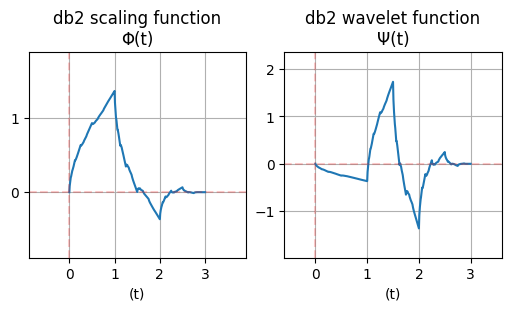

In [17]:
plot_wpt_fun(wpt_fun, (0.3, 0.2), step1=(1, 1), step2=(1, 1), figsize=(5, 3))

In [18]:
img_trans_norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
img_trans_norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [19]:
# Input Image height/width in pixels
in_img_size = int(df_all.iloc[0, 1])

channels = len(df_all.iloc[0, 3])

image_new_size = in_img_size

if image_new_size != in_img_size:
  image_t=v2.Resize(image_new_size)(r_img)
else:
  image_t = r_img

# The height/width of a wpt decomposition in pixels
# note that the wpt decomposition (and not the original image) will be the actual input to the VIT model
wpt_img_size = wpt_dec(image_t, wpt_fun, wpt_level)[1].shape[1]

# The height/width of a patch in pixels (patch is a slice of a WPT decomposition)
patch_size = wpt_img_size

features = ((2**wpt_level)**2) if wpt_slice==None else len(wpt_slice)   # 16 for level 2

# No. of patches(slices) per WPT decomposition
patches_per_dec = (wpt_img_size//patch_size)**2

# Each patch (slice) will be flattened into a row vector of size (3 Channels x Patch_size x Patch_size)
patch_flat_size = (channels) * patch_size**2

# the flattened patch will be passed first through a linear layer with output embed_size
# in this case I will keep the same dimension
embed_size = patch_flat_size

# dim of the last mlp classifier
mlp_dim = embed_size*4#384

# The larger the batch size the faster convergence to the optimum parameters
# The downside is the larger model size and GPU memory consumed
train_batch_size = 1000  # https://www.youtube.com/watch?v=Owm1H0ukjS4
valid_batch_size = 1000
test_batch_size = 1000

# We have 2 classes: Real or Fake
num_classes = 2
encoder_depth = 2

# always take care that embed_size is divisible by the number of attention heads
attention_heads = 18

# Whether we want to calculate attention of each patch with only its previous patches (in this case Causal is True)
# or with all (before and after) patches in the sequence (in this case Causal is False)
is_causal = False

print(f'Size of the original image: {in_img_size}x{in_img_size} ')
print(f'Size of the resized image: {image_new_size}x{image_new_size} ')
print(f'Size of the WPT decomposition : {wpt_img_size}x{wpt_img_size}')
print(f'Size of single patch(slice): {patch_size}x{patch_size}')
print(f'Patch flattened vector size: {patch_size}x{patch_size}x{channels} = {patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')
print()
print(f'No. of WPT decompositions of the image: {features}')
print(f'No. of patches per WPT decomposition: {patches_per_dec}')
print(f'Total No of patches : {features}x{patches_per_dec} = {features*patches_per_dec}')

Size of the original image: 32x32 
Size of the resized image: 32x32 
Size of the WPT decomposition : 6x6
Size of single patch(slice): 6x6
Patch flattened vector size: 6x6x3 = 108
Embedding Size: 108
Output MLP size: 432

No. of WPT decompositions of the image: 64
No. of patches per WPT decomposition: 1
Total No of patches : 64x1 = 64


In [20]:
base_lr = 0.1         # Base Learning rate 0.1 for SGD , 0.0001 for Adam
momentum = 0.9          # Momentum for SGD
weight_decay = 0.001     # Weight decay for Adam

if start_from_model & continue_lr:
    use_lr = checkpoint['running_lr_lst'][-1]
else:
    use_lr = base_lr


loss_algo = CrossEntropyLoss

optimize_algo = SGD  # Adam
optimize_args = {"lr": use_lr,
                 #  "weight_decay": weight_decay ,
                 "momentum": momentum
                 }

schedule_algo = CosineAnnealingLR # ReduceLROnPlateau
schedule_args = {"T_max":n_extra_epochs}#{"factor": 0.5, "mode": "max"}

In [21]:
hyper_parameters = {
    "training_phase": training_phase,
    "model_type": model_type,
    "wpt_fun": wpt_fun,
    "wpt_level": wpt_level,
    "wpt_mode": wpt_mode,
    "wpt_slice": wpt_slice,
    "channels": channels,
    "img_trans_norm_mean": img_trans_norm_mean,
    "img_trans_norm_std": img_trans_norm_std,
    "in_img_size": in_img_size,
    "image_new_size": image_new_size,
    "wpt_img_size": wpt_img_size,
    "patch_size": patch_size,
    "features": features,
    "patches_per_dec": patches_per_dec,
    "patch_flat_size": patch_flat_size,
    "embed_size": embed_size,
    "mlp_dim": mlp_dim,
    "train_batch_size": train_batch_size,
    "valid_batch_size": valid_batch_size,
    "num_classes": num_classes,
    "encoder_depth": encoder_depth,
    "attention_heads": attention_heads,
    "is_causal": is_causal,
    "n_extra_epochs ": n_extra_epochs,
    "base_lr": base_lr,
    "momentum": momentum,
    "weight_decay": weight_decay,
    "loss_algo": loss_algo,
    "optimize_algo": optimize_algo,
    "optimize_args": optimize_args,
    "use_scheduler": use_scheduler,
    "schedule_algo": schedule_algo,
    "schedule_args": schedule_args
}

hyper_parameters

{'training_phase': 1,
 'model_type': 'vit',
 'wpt_fun': 'db2',
 'wpt_level': 3,
 'wpt_mode': 'symmetric',
 'wpt_slice': None,
 'channels': 3,
 'img_trans_norm_mean': [0.4913997551666284,
  0.48215855929893703,
  0.4465309133731618],
 'img_trans_norm_std': [0.24703225141799082,
  0.24348516474564,
  0.2615878392604963],
 'in_img_size': 32,
 'image_new_size': 32,
 'wpt_img_size': 6,
 'patch_size': 6,
 'features': 64,
 'patches_per_dec': 1,
 'patch_flat_size': 108,
 'embed_size': 108,
 'mlp_dim': 432,
 'train_batch_size': 1000,
 'valid_batch_size': 1000,
 'num_classes': 2,
 'encoder_depth': 2,
 'attention_heads': 18,
 'is_causal': False,
 'n_extra_epochs ': 200,
 'base_lr': 0.1,
 'momentum': 0.9,
 'weight_decay': 0.001,
 'loss_algo': torch.nn.modules.loss.CrossEntropyLoss,
 'optimize_algo': torch.optim.sgd.SGD,
 'optimize_args': {'lr': 0.1, 'momentum': 0.9},
 'use_scheduler': False,
 'schedule_algo': torch.optim.lr_scheduler.CosineAnnealingLR,
 'schedule_args': {'T_max': 200}}

In [22]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
# replaced the attention mechanism with MHA from Sebastian Raschka

# helpers
def mask(x_size, patches_per_dec, features, heads):

    # patches_per_dec : is the number of patches per each wpt decomposition
    # x_size is the shape of the Transformer (MHA) input, it has the shape:
    # (batch_size, patches"including the first position patch",patch embedding_size)

    # The smallest granularity of mask is a whole WPT decomposition

    a0 = torch.zeros(patches_per_dec, patches_per_dec, dtype=torch.int)
    a1 = torch.ones(patches_per_dec, patches_per_dec, dtype=torch.int)
    a = torch.stack((a0, a1))

    batch_size = x_size[0]
    patches = x_size[1]

    # features

    b = torch.ones(features,  features, dtype=torch.int32).tril(0)
    c = a[b]
    e = rearrange(c, "a b c d -> (a c)(b d)")

    pos_col = torch.ones(patches-1, 1, dtype=torch.int32)
    pos_row = torch.zeros(1, patches, dtype=torch.int32)

    f = torch.concat((pos_col, e), dim=1)
    mask = torch.concat((pos_row, f), dim=0)
    mask[0, 0] = 1

    mask = mask[None, None, :, :]
    mask = mask.repeat(batch_size, heads, 1, 1)
    mask = mask.to(dtype=torch.bool)

    return mask


class WPT2D(nn.Module):
    def __init__(self, wpt_fun, wpt_level, mode, slice):
        super().__init__()
        self.wpt_fun = wpt_fun
        self.wpt_level = wpt_level
        self.mode = mode
        self.slice = slice

    def forward(self, x):

        *_, nodes_tensor = wpt_dec(x, self.wpt_fun, level=self.wpt_level, mode=self.mode, slice=self.slice)

        return nodes_tensor


class Patch_Embed(nn.Module):
    def __init__(self, patch_size, patch_dim, embed_size):
        super().__init__()
        self.patch_embed = nn.Sequential(
            # This rearrangement is suitable for the wavelet packet features
            # torch.Size([200, 16, 3, 32, 32])
            Rearrange('b f c (h p1) (w p2) -> b (f h w) (c p1 p2)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_dim, embed_size),
        )

    def forward(self, x):
        return self.patch_embed(x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)


# inspired by Sebstian Raschka with modifications
class MHA(nn.Module):
    def __init__(self, patches_per_dec, features, embed_size, heads, is_causal, dropout):
        super().__init__()
        self.embed_size = embed_size
        self.inner_dim = embed_size*2
        self.heads = heads
        self.dim_per_head = self.inner_dim // self.heads
        self.Wq = nn.Linear(in_features=embed_size, out_features=self.inner_dim)
        self.Wk = nn.Linear(in_features=embed_size, out_features=self.inner_dim)
        self.Wv = nn.Linear(in_features=embed_size, out_features=self.inner_dim)
        self.softmax = nn.Softmax(dim=-1)

        self.dropout = dropout
        self.linear = nn.Linear( in_features=self.inner_dim, out_features=embed_size)
        self.is_causal = is_causal
        self.patches_per_dec = patches_per_dec
        self.features = features

    def forward(self, x):

        attn_bias = torch.zeros(x.size(0), self.heads, x.size(1), x.size(1), dtype=x.dtype).to(device)

        if self.is_causal:
            temp_mask = mask(x.shape, self.patches_per_dec, self.features, self.heads).to(device)
            attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
            attn_bias.to(dtype=x.dtype)

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        
        Q = rearrange(q, 'b s (h d) -> b h s d', h=self.heads, d=self.dim_per_head)
        K = rearrange(k, 'b s (h d) -> b h s d', h=self.heads, d=self.dim_per_head)
        V = rearrange(v, 'b s (h d) -> b h s d', h=self.heads, d=self.dim_per_head)

        scale_factor = self.dim_per_head**0.5

        use_dropout = 0.0 if not self.training else self.dropout

        # Note:

        # # Q(b h s d) . KT(b h d s) ==> b h s s
        QK = Q @ K.transpose(-2, -1) * scale_factor

        if self.is_causal:
            QK_and_bias = QK+attn_bias
            # b h s s ==> b h s s
            weight = self.softmax(QK_and_bias)
        else:
            weight = self.softmax(QK)

        weight_drop = torch.dropout(weight, use_dropout, train=True)

        # # weight(b h s s).V(b h s d) ==> attention (b h s d)
        attention = weight_drop @ V

        attention = rearrange(attention, 'b h s d -> b s (h d)')
        attention = self.linear(attention)
        return attention


class Transformer(nn.Module):
    def __init__(self, patches_per_dec, features, embed_size, depth, mlp_dim, heads, is_causal, dropout):
        super().__init__()

        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [PreNorm(embed_size, MHA(patches_per_dec, features, embed_size, heads, is_causal, dropout)),
                     PreNorm(embed_size, FeedForward(embed_size, mlp_dim, dropout=dropout))]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class vit(nn.Module):
    def __init__(self, num_classes, channels, features, slice, patches_per_dec, patch_size, embed_size, wpt_fun, wpt_level, mode, depth, heads, mlp_dim, is_causal, emb_dropout, enc_dropout):

        super().__init__()

        # num_classes: Number of classes to be learned (2 for the binary Deep Fake Identification Problem)
        # channels: Channels of the image (3 for colored images)
        # features: No. of WPT decompositions per an image
        # slice: which WPT decompositions will be considered as input for the model
        # patches_per_dec: No. of patches per a single WPT decomposition 
        # patch_size: the height or width of 2D patch (slice)
        # embed_size: the flattend size for each patch token before entering the encoder stage 
        # wpt_fun: The Wavelet Function
        # wpt_level: The maximum Level to which an Image will be decomposed
        # mode: How WPT will deal with the edges of the image (padding)
        # depth: Number of stacked encoders in the transformer
        # heads: Number of heads in the encoders
        # mlp_dim: size of the last MLP layer after existing the transformer 
        # is_causal: if True then token will not calculate attention with the next (future) tokens in the input sequence  
        # emb_dropout: dropout ratio before entering the transformer (to reduce overfitting)
        # enc_dropout: dropout ratio inside each encoder of the transformer (to reduce overfitting)  

        patch_dim = channels * patch_size**2
        num_patches = patches_per_dec * features

        self.to_wpt2d = WPT2D(wpt_fun, wpt_level, mode, slice)
        self.to_patch_embedding = Patch_Embed(patch_size, patch_dim, embed_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_size))
        
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(patches_per_dec, features, embed_size, depth, mlp_dim, heads, is_causal, enc_dropout)

        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        )

    def forward(self, img):

        # First: Output the WPT decompositions of the input image
        img_wpt = self.to_wpt2d(img)

        # Second: slice every WPT decomposition into patches(slices)
        x = self.to_patch_embedding(img_wpt)

        # Third: add class token and positional embedding

            # input x.shape: (batch_size , num_patches , embed_size)
        b, *_ = x.shape
        
            # cls_token.shape: (1 , 1 , embed_size)
            # cls_tokens.shape: (batch_size , 1 , embed_size)
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        
            # new x.shape: (batch_size , num_patches + 1 , embed_size)
        x = torch.cat((cls_tokens, x), dim=1)

            # pos_embedding.shape: (batch_size , num_patches + 1 , embed_size)
        x += self.pos_embedding

        # Fourth: transformer 
        x = self.dropout(x)
        x = self.transformer(x)

        x = x[:, 0]  # x.mean(dim=1)

        x = self.to_latent(x)

        # Fifth: output MLP Layer 
        out = self.mlp_head(x)

        return out 

In [23]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):

        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):

        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(self.annotation.iloc[index, 5], dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = img

        return img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [24]:
if image_new_size != in_img_size:
    transform_train = transforms.Compose([
        v2.Resize(size=image_new_size),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

    transform_valid = transforms.Compose([
        v2.Resize(size=image_new_size),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

else:
    transform_train = transforms.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

    transform_valid = transforms.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])

In [25]:
# Define the dataset object and configure the Data Loader

train_set = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set = Images_Dataset(df_val, transform_valid)

valid_loader = DataLoader(dataset=valid_set,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [26]:
print("Total number of training batches:", len(train_loader))
print("Total number of validation batches:", len(valid_loader))

Total number of training batches: 100
Total number of validation batches: 20


In [27]:
sample_imgt_bch, label_bch = next(iter(train_loader))

In [28]:
print(f"Batch of Images Shape: {sample_imgt_bch.size()}")
print(f"Batch of Labels Shape: {label_bch.size()}")

Batch of Images Shape: torch.Size([1000, 3, 32, 32])
Batch of Labels Shape: torch.Size([1000])


In [29]:
sample_img_idx = 12

sample_img = sample_imgt_bch[sample_img_idx, :, :, :]
sample_img.shape

torch.Size([3, 32, 32])

In [30]:
_, nodes, _ = wpt_dec(img=sample_img, wavelet_fun=wpt_fun, level=wpt_level, mode=wpt_mode, slice=wpt_slice)

In [31]:
sample_img_a = norm_to_plot(sample_img)
sample_img_a.shape

(32, 32, 3)

Text(0.5, 1.0, 'Label: Real')

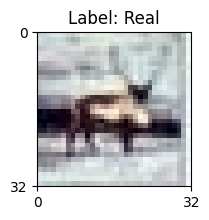

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

n = sample_img_a.shape[0]
extent = [0, n, n, 0]

ax.imshow(norm_to_plot(sample_img_a), extent=extent)
ax.set(xticks=np.arange(0, sample_img_a.shape[1]+1, step=32),
       yticks=np.arange(0, sample_img_a.shape[0]+1, step=32))
ax.set_title(
    f'Label: {"Real" if label_bch[sample_img_idx].item()==1 else "Fake"}')

In [33]:
print(sample_img.shape)

torch.Size([3, 32, 32])


/home/osmahus/pytVenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


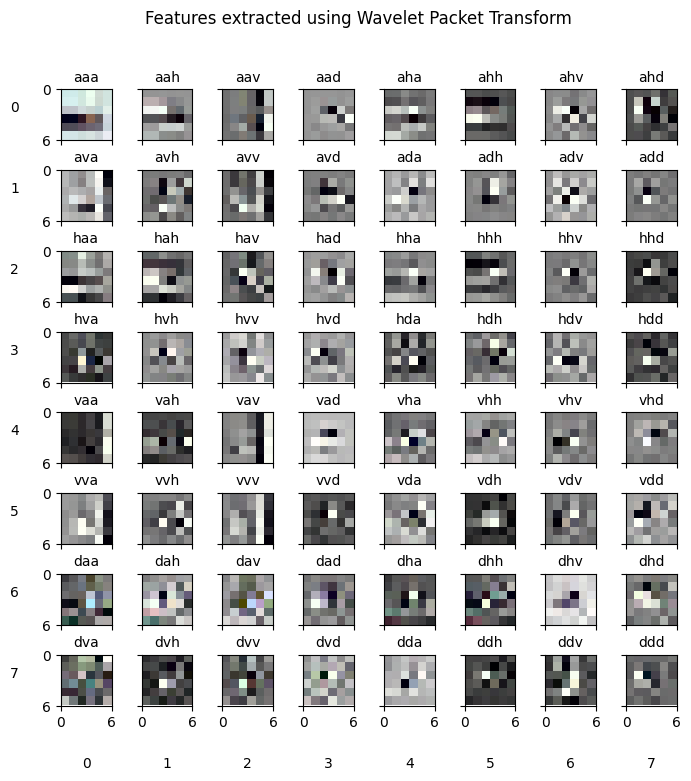

In [34]:
plot_wpt_nodes(sample_img, wpt_fun, wpt_level, setticks=6, slice=wpt_slice, figsize=(8, 8))

Shape of the image patches matrix:  (1, 1, 6, 6, 3)


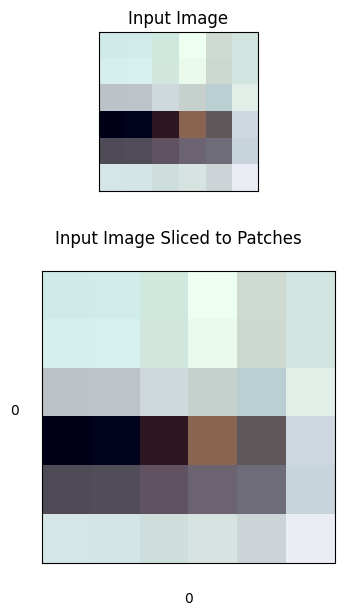

In [35]:
img_plot(nodes[0, :, :, :], slice_width=patch_size, figsize=(8, 6), setticks1=None, setticks2=None, axes_pad=0.15)

Shape of the image patches matrix:  (1, 1, 6, 6, 3)


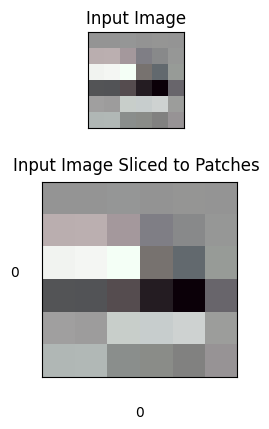

In [36]:
if wpt_level != 0:
    img_plot(nodes[1, :, :, :], slice_width=patch_size, figsize=(3, 4), setticks1=None, setticks2=None, axes_pad=0.15)

In [37]:
if model_type == "vit":
    model = vit(
        num_classes=num_classes,
        channels=channels,
        features=features,
        slice=wpt_slice,
        patches_per_dec=patches_per_dec,
        patch_size=patch_size,
        embed_size=embed_size,
        wpt_fun=wpt_fun,
        wpt_level=wpt_level,
        mode=wpt_mode,
        depth=encoder_depth,
        heads=attention_heads,
        mlp_dim=mlp_dim,
        is_causal=is_causal,
        emb_dropout=0.1,
        enc_dropout=0.1,
    )
else:
    raise ValueError(
        "You must set the model_type variable to any of: vit ,....")

In [38]:
summary(model=model,
        input_size=sample_imgt_bch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
vit (vit)                                          [1000, 3, 32, 32]    [1000, 2]            7,128                True
├─WPT2D (to_wpt2d)                                 [1000, 3, 32, 32]    [1000, 64, 3, 6, 6]  --                   --
├─Patch_Embed (to_patch_embedding)                 [1000, 64, 3, 6, 6]  [1000, 64, 108]      --                   True
│    └─Sequential (patch_embed)                    [1000, 64, 3, 6, 6]  [1000, 64, 108]      --                   True
│    │    └─Rearrange (0)                          [1000, 64, 3, 6, 6]  [1000, 64, 108]      --                   --
│    │    └─Linear (1)                             [1000, 64, 108]      [1000, 64, 108]      11,772               True
├─Dropout (dropout)                                [1000, 65, 108]      [1000, 65, 108]      --                   --
├─Transformer (transformer)                      

In [39]:
criterion = loss_algo()
optimizer = optimize_algo(model.parameters(), **optimize_args)
scheduler = schedule_algo(optimizer, **schedule_args)

In [40]:
if start_from_model:
    model.load_state_dict(checkpoint['model'])
    if checkpoint['optimizer_lst'][-1] == optimize_algo:
        optimizer.load_state_dict(checkpoint['optimizer'])

    best_acc = checkpoint['best_acc']
    epoch_lst = checkpoint['epoch_lst']
    tr_loss_lst = checkpoint['tr_loss_lst']
    tr_acc_lst = checkpoint['tr_acc_lst']
    val_loss_lst = checkpoint['val_loss_lst']
    val_acc_lst = checkpoint['val_acc_lst']
    optimizer_lst = checkpoint['optimizer_lst']
    running_lr_lst = checkpoint['running_lr_lst']
    training_phase_lst = checkpoint['training_phase_lst']
    hyper_parameters_lst = checkpoint['hyper_parameters_lst']
    accumulate_duration_lst = checkpoint['accumulate_duration_lst']
    model_file_name_lst = checkpoint['model_file_name_lst']

else:
    
    best_acc = 0
    epoch_lst = []
    tr_loss_lst = []
    tr_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []
    optimizer_lst = []
    running_lr_lst = []
    training_phase_lst = []
    hyper_parameters_lst = []
    accumulate_duration_lst = []
    model_file_name_lst = []

In [41]:
training_start_time = time.time()

model.to(device)
for epoch in range(start_epoch, end_epoch):
    epoch_start_time = time.time()

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0
    running_lr = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (*_, inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path
        loss.backward()

        running_lr += optimizer.param_groups[-1]['lr']

        # Optimizer Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total
        avg_running_lr = running_lr/(batch_idx+1)

        loop1.set_description(f"Train--Epoch [{epoch+1}/{end_epoch}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (*_, inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{end_epoch}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)
    ##########################################################

    epoch_end_time = time.time()

    epoch_duration = epoch_end_time-epoch_start_time
    epoch_duration_str = time.strftime("%H:%M:%S", time.gmtime(epoch_duration))
    previous_duration = accumulate_duration_lst[-1] if len(accumulate_duration_lst) != 0 else 0
    accumulate_duration = epoch_duration+previous_duration
    accumulate_duration_str = time.strftime("%H:%M:%S", time.gmtime(accumulate_duration))
    print(f'epoch duration(H:M:S):- {epoch_duration_str}   accumulate duration(H:M:S):- {accumulate_duration_str}')

    model_file_name = f'{model_code}_ph{training_phase}_ep{epoch+1}_acc{avg_val_accuracy:.2f}'

    ##########################################################

    epoch_lst.append(epoch+1)
    tr_loss_lst.append(avg_tr_loss)
    tr_acc_lst.append(avg_tr_accuracy)
    val_loss_lst.append(avg_val_loss)
    val_acc_lst.append(avg_val_accuracy)
    optimizer_lst.append(type(optimizer).__name__)
    running_lr_lst.append(avg_running_lr)
    training_phase_lst.append(training_phase)
    hyper_parameters_lst.append(hyper_parameters)
    accumulate_duration_lst.append(accumulate_duration)
    model_file_name_lst.append(model_file_name)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving...')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "best_acc": best_acc,
                 "epoch_lst": epoch_lst,
                 "tr_loss_lst": tr_loss_lst,
                 "tr_acc_lst": tr_acc_lst,
                 "val_loss_lst": val_loss_lst,
                 "val_acc_lst": val_acc_lst,
                 "optimizer_lst": optimizer_lst,
                 "running_lr_lst": running_lr_lst,
                 "training_phase_lst": training_phase_lst,
                 "hyper_parameters_lst": hyper_parameters_lst,
                 "accumulate_duration_lst": accumulate_duration_lst,
                 "model_file_name_lst":model_file_name_lst
                 }
        torch.save(state, model_state_path + model_file_name)

    ##########################################################

    if use_scheduler:
        scheduler.step(val_acc_lst[-1])  # step scheduling
    print()


training_end_time = time.time()
total_duration = training_end_time-training_start_time
total_duration_str = time.strftime("%H:%M:%S", time.gmtime(total_duration))
print()
print(f'Total Training Time(H:M:S):- {total_duration_str}')

Valid--Epoch [1/200]: 100%|██████████| 20/20 [00:04<00:00,  4.71it/s, acc=70.4, loss=0.576]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:00:30
Saving...




Valid--Epoch [2/200]: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s, acc=78, loss=0.463]  


epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:01:00
Saving...



Valid--Epoch [3/200]: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s, acc=81.3, loss=0.409]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:01:31
Saving...




Valid--Epoch [4/200]: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s, acc=81.9, loss=0.393]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:02:01
Saving...




Valid--Epoch [5/200]: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s, acc=83.2, loss=0.373]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:02:31
Saving...




Valid--Epoch [6/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=82.2, loss=0.391]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:03:01



Valid--Epoch [7/200]: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s, acc=82.9, loss=0.378]

epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:03:32




Valid--Epoch [8/200]: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s, acc=84.7, loss=0.352]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:04:02
Saving...




Valid--Epoch [9/200]: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s, acc=80.3, loss=0.432]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:04:32




Valid--Epoch [10/200]: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s, acc=84, loss=0.365]  


epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:05:02



Valid--Epoch [11/200]: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s, acc=86.6, loss=0.318]


epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:05:32
Saving...



Valid--Epoch [12/200]: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s, acc=84.8, loss=0.355]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:06:02




Valid--Epoch [13/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=86.1, loss=0.324]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:06:33




Valid--Epoch [14/200]: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s, acc=83.7, loss=0.384]


epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:07:03



Valid--Epoch [15/200]: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s, acc=86, loss=0.325]  

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:07:34




Valid--Epoch [16/200]: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s, acc=86.5, loss=0.313]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:08:04




Valid--Epoch [17/200]: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, acc=86.5, loss=0.318]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:08:35




Valid--Epoch [18/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=86, loss=0.331]  

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:09:05




Valid--Epoch [19/200]: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s, acc=87.4, loss=0.3]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:09:35
Saving...




Valid--Epoch [20/200]: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, acc=86.8, loss=0.316]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:10:06




Valid--Epoch [21/200]: 100%|██████████| 20/20 [00:04<00:00,  4.21it/s, acc=84.5, loss=0.362] 

epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:10:37




Valid--Epoch [22/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=88.1, loss=0.287]

epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:11:09
Saving...




Valid--Epoch [23/200]: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s, acc=88, loss=0.292]  

epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:11:40




Valid--Epoch [24/200]: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s, acc=88.2, loss=0.285]

epoch duration(H:M:S):- 00:00:32   accumulate duration(H:M:S):- 00:12:13
Saving...




Valid--Epoch [25/200]: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, acc=87.1, loss=0.318]

epoch duration(H:M:S):- 00:00:32   accumulate duration(H:M:S):- 00:12:45




Valid--Epoch [26/200]: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s, acc=88, loss=0.293]  

epoch duration(H:M:S):- 00:00:32   accumulate duration(H:M:S):- 00:13:17




Valid--Epoch [27/200]: 100%|██████████| 20/20 [00:05<00:00,  4.00it/s, acc=87.1, loss=0.31] 

epoch duration(H:M:S):- 00:00:32   accumulate duration(H:M:S):- 00:13:49




Valid--Epoch [28/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=89.3, loss=0.258]


epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:14:21
Saving...



Valid--Epoch [29/200]: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s, acc=87, loss=0.323]   

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:14:51




Valid--Epoch [30/200]: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s, acc=86.6, loss=0.331]

epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:15:23




Valid--Epoch [31/200]: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, acc=88.4, loss=0.28] 

epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:15:54




Valid--Epoch [32/200]: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, acc=87.1, loss=0.321] 

epoch duration(H:M:S):- 00:00:31   accumulate duration(H:M:S):- 00:16:25




Valid--Epoch [33/200]: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, acc=89.5, loss=0.258]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:16:54
Saving...



Valid--Epoch [34/200]: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, acc=89.2, loss=0.26] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:17:23




Valid--Epoch [35/200]: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s, acc=88.5, loss=0.288] 

epoch duration(H:M:S):- 00:00:28   accumulate duration(H:M:S):- 00:17:52




Valid--Epoch [36/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=89.7, loss=0.252]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:18:22
Saving...




Valid--Epoch [37/200]: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, acc=89.5, loss=0.264]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:18:52




Valid--Epoch [38/200]: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s, acc=89, loss=0.267]  

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:19:23




Valid--Epoch [39/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=90.7, loss=0.234]


epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:19:54
Saving...



Valid--Epoch [40/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=89.3, loss=0.273]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:20:24




Valid--Epoch [41/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=88.7, loss=0.288] 


epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:20:54



Valid--Epoch [42/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=89.6, loss=0.261]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:21:24




Valid--Epoch [43/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=87.3, loss=0.325] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:21:53



Valid--Epoch [44/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=90.4, loss=0.239]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:22:22




Valid--Epoch [45/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=88, loss=0.314]   

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:22:51




Valid--Epoch [46/200]: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s, acc=89.1, loss=0.288] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:23:21




Valid--Epoch [47/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=90.8, loss=0.228]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:23:50
Saving...



Valid--Epoch [48/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=89.3, loss=0.279] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:24:19




Valid--Epoch [49/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=90.8, loss=0.227]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:24:49
Saving...



Valid--Epoch [50/200]: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s, acc=89.7, loss=0.263]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:25:18




Valid--Epoch [51/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=90.3, loss=0.244]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:25:47



Valid--Epoch [52/200]: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s, acc=89.2, loss=0.282] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:26:16




Valid--Epoch [53/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=89.7, loss=0.268]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:26:46




Valid--Epoch [54/200]: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s, acc=88.3, loss=0.316] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:27:15




Valid--Epoch [55/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=90.4, loss=0.242]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:27:44




Valid--Epoch [56/200]: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, acc=90.8, loss=0.23] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:28:13




Valid--Epoch [57/200]: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s, acc=90.8, loss=0.23] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:28:42




Valid--Epoch [58/200]: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s, acc=90.6, loss=0.245]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:29:12




Valid--Epoch [59/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=90, loss=0.258]   

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:29:41




Valid--Epoch [60/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=91, loss=0.234]  


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:30:10
Saving...



Valid--Epoch [61/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=91.6, loss=0.215]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:30:39
Saving...



Valid--Epoch [62/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=89.8, loss=0.271]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:31:09




Valid--Epoch [63/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=91, loss=0.225]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:31:38




Valid--Epoch [64/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=90.9, loss=0.239]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:32:07




Valid--Epoch [65/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=89.7, loss=0.281] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:32:37




Valid--Epoch [66/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=90.3, loss=0.26] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:33:06




Valid--Epoch [67/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=90.8, loss=0.244]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:33:35




Valid--Epoch [68/200]: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s, acc=90.2, loss=0.258] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:34:04




Valid--Epoch [69/200]: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s, acc=91.4, loss=0.225]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:34:33




Valid--Epoch [70/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=89.7, loss=0.288] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:35:03




Valid--Epoch [71/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=91.1, loss=0.236]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:35:32



Valid--Epoch [72/200]: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s, acc=89, loss=0.321]   

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:36:01




Valid--Epoch [73/200]: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s, acc=88.9, loss=0.325] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:36:30




Valid--Epoch [74/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=90.9, loss=0.249]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:37:00




Valid--Epoch [75/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=90.9, loss=0.246]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:37:29




Valid--Epoch [76/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.3, loss=0.235]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:37:58




Valid--Epoch [77/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.1, loss=0.247]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:38:27




Valid--Epoch [78/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=90.2, loss=0.271] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:38:56




Valid--Epoch [79/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=91.7, loss=0.224]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:39:25
Saving...



Valid--Epoch [80/200]: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s, acc=91.1, loss=0.247]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:39:55




Valid--Epoch [81/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=90.7, loss=0.258]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:40:24



Valid--Epoch [82/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=90.8, loss=0.259]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:40:53



Valid--Epoch [83/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=91.6, loss=0.224]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:41:22




Valid--Epoch [84/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=91, loss=0.263]   

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:41:52




Valid--Epoch [85/200]: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s, acc=91.2, loss=0.244]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:42:21




Valid--Epoch [86/200]: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, acc=90.5, loss=0.274] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:42:50




Valid--Epoch [87/200]: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s, acc=90.3, loss=0.279]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:43:19



Valid--Epoch [88/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.1, loss=0.249]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:43:49




Valid--Epoch [89/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=90.9, loss=0.265]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:44:18




Valid--Epoch [90/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=92, loss=0.222]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:44:47
Saving...




Valid--Epoch [91/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=90.8, loss=0.27] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:45:17



Valid--Epoch [92/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=90.1, loss=0.291] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:45:46




Valid--Epoch [93/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=91, loss=0.266]   

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:46:15




Valid--Epoch [94/200]: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s, acc=90.9, loss=0.276] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:46:44




Valid--Epoch [95/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=92.2, loss=0.217]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:47:14
Saving...




Valid--Epoch [96/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=90.6, loss=0.279]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:47:43




Valid--Epoch [97/200]: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, acc=91.1, loss=0.26] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:48:12



Valid--Epoch [98/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=91.5, loss=0.252]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:48:42




Valid--Epoch [99/200]: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s, acc=91.3, loss=0.265]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:49:11



Valid--Epoch [100/200]: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s, acc=91.6, loss=0.243]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:49:41




Valid--Epoch [101/200]: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s, acc=92, loss=0.225]  


epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:50:11



Valid--Epoch [102/200]: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s, acc=91, loss=0.274]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:50:40




Valid--Epoch [103/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=90.2, loss=0.309]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:51:10




Valid--Epoch [104/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=92, loss=0.228]  


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:51:40



Valid--Epoch [105/200]: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s, acc=91.3, loss=0.264]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:52:09




Valid--Epoch [106/200]: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s, acc=91.2, loss=0.272]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:52:39




Valid--Epoch [107/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=91.6, loss=0.258]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:53:09




Valid--Epoch [108/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=92.4, loss=0.222]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:53:39
Saving...



Valid--Epoch [109/200]: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s, acc=91.5, loss=0.257]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:54:09




Valid--Epoch [110/200]: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, acc=91.4, loss=0.267]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:54:40




Valid--Epoch [111/200]: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s, acc=91.2, loss=0.279] 

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 00:55:10




Valid--Epoch [112/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=91.4, loss=0.275]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:55:40




Valid--Epoch [113/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=91, loss=0.289]  


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:56:09



Valid--Epoch [114/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=91.3, loss=0.28] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:56:38



Valid--Epoch [115/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=91.3, loss=0.262]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:57:08




Valid--Epoch [116/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=91.5, loss=0.259]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:57:37




Valid--Epoch [117/200]: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, acc=91.6, loss=0.284]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:58:06




Valid--Epoch [118/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=90.5, loss=0.324]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:58:36




Valid--Epoch [119/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=91.6, loss=0.28] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:59:05



Valid--Epoch [120/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=92, loss=0.253]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 00:59:34




Valid--Epoch [121/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=91, loss=0.303]   


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:00:04



Valid--Epoch [122/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.6, loss=0.281]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:00:33




Valid--Epoch [123/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=91.9, loss=0.266]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:01:02




Valid--Epoch [124/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=90.8, loss=0.303] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:01:31




Valid--Epoch [125/200]: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s, acc=91.8, loss=0.263]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:02:01




Valid--Epoch [126/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=92.2, loss=0.264]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:02:30




Valid--Epoch [127/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=91.7, loss=0.284]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:03:00



Valid--Epoch [128/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=92.2, loss=0.26] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:03:29



Valid--Epoch [129/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=91.3, loss=0.287]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:03:58



Valid--Epoch [130/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=91.8, loss=0.276]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:04:27



Valid--Epoch [131/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.5, loss=0.299]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:04:57




Valid--Epoch [132/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=91.5, loss=0.294]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:05:26




Valid--Epoch [133/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=91.8, loss=0.299]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:05:55



Valid--Epoch [134/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=92.4, loss=0.27] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:06:25



Valid--Epoch [135/200]: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s, acc=91.1, loss=0.306]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:06:54



Valid--Epoch [136/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=91.6, loss=0.308]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:07:23




Valid--Epoch [137/200]: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, acc=91.2, loss=0.311]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:07:52



Valid--Epoch [138/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.7, loss=0.296]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:08:22




Valid--Epoch [139/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=91.9, loss=0.301]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:08:51




Valid--Epoch [140/200]: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s, acc=91.5, loss=0.299]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:09:20




Valid--Epoch [141/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=90, loss=0.38]    

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:09:50




Valid--Epoch [142/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=92.5, loss=0.266]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:10:19
Saving...



Valid--Epoch [143/200]: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, acc=92.1, loss=0.299]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:10:48




Valid--Epoch [144/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=92, loss=0.291]  


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:11:18



Valid--Epoch [145/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=92.3, loss=0.281]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:11:47




Valid--Epoch [146/200]: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, acc=91.8, loss=0.303]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:12:16




Valid--Epoch [147/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=91.4, loss=0.337]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:12:45




Valid--Epoch [148/200]: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s, acc=91.8, loss=0.293]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:13:15




Valid--Epoch [149/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=92.5, loss=0.28] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:13:44
Saving...



Valid--Epoch [150/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=92, loss=0.309]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:14:14




Valid--Epoch [151/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=90.8, loss=0.363]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:14:43




Valid--Epoch [152/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=92.8, loss=0.275]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:15:12
Saving...



Valid--Epoch [153/200]: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, acc=91.6, loss=0.329]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:15:42




Valid--Epoch [154/200]: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, acc=92.2, loss=0.298]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:16:11




Valid--Epoch [155/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=92, loss=0.31]   


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:16:41



Valid--Epoch [156/200]: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s, acc=92.3, loss=0.294]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:17:10




Valid--Epoch [157/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=91.1, loss=0.366]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:17:40



Valid--Epoch [158/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=90.5, loss=0.395]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:18:09



Valid--Epoch [159/200]: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, acc=92.1, loss=0.297]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:18:38




Valid--Epoch [160/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=92.2, loss=0.283]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:19:08




Valid--Epoch [161/200]: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s, acc=91.8, loss=0.326]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:19:37




Valid--Epoch [162/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=92.4, loss=0.285]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:20:06




Valid--Epoch [163/200]: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s, acc=90.9, loss=0.379]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:20:35



Valid--Epoch [164/200]: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s, acc=91, loss=0.364]  


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:21:05



Valid--Epoch [165/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=92, loss=0.309]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:21:34




Valid--Epoch [166/200]: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s, acc=92.8, loss=0.269]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:22:03




Valid--Epoch [167/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=92.3, loss=0.29] 

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:22:33




Valid--Epoch [168/200]: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s, acc=91.9, loss=0.313]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:23:02




Valid--Epoch [169/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=92.1, loss=0.299]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:23:32




Valid--Epoch [170/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=91.9, loss=0.345]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:24:01




Valid--Epoch [171/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=92.2, loss=0.307]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:24:31




Valid--Epoch [172/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=92.2, loss=0.317]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:25:00



Valid--Epoch [173/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=91.9, loss=0.319]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:25:30



Valid--Epoch [174/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=91.7, loss=0.318]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:25:59




Valid--Epoch [175/200]: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, acc=91.8, loss=0.334]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:26:28



Valid--Epoch [176/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.8, loss=0.34] 


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:26:58



Valid--Epoch [177/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=92.5, loss=0.301]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:27:27



Valid--Epoch [178/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=91.8, loss=0.337]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:27:56




Valid--Epoch [179/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=92.8, loss=0.285]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:28:26




Valid--Epoch [180/200]: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s, acc=91.8, loss=0.334]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:28:55




Valid--Epoch [181/200]: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s, acc=92.2, loss=0.313]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:29:25




Valid--Epoch [182/200]: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s, acc=91.9, loss=0.326]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:29:54




Valid--Epoch [183/200]: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s, acc=91.9, loss=0.313]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:30:24



Valid--Epoch [184/200]: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, acc=91.6, loss=0.348]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:30:54




Valid--Epoch [185/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=92.6, loss=0.287]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:31:24




Valid--Epoch [186/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=92.2, loss=0.317]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:31:53




Valid--Epoch [187/200]: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s, acc=91.8, loss=0.343]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:32:23



Valid--Epoch [188/200]: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, acc=92.3, loss=0.334]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:32:53




Valid--Epoch [189/200]: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s, acc=92.6, loss=0.291]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:33:23




Valid--Epoch [190/200]: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s, acc=92, loss=0.328]  

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 01:33:53




Valid--Epoch [191/200]: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, acc=91.8, loss=0.328]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 01:34:23




Valid--Epoch [192/200]: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s, acc=92.1, loss=0.319]

epoch duration(H:M:S):- 00:00:30   accumulate duration(H:M:S):- 01:34:54




Valid--Epoch [193/200]: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s, acc=91.9, loss=0.343]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:35:23



Valid--Epoch [194/200]: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, acc=91.8, loss=0.351]


epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:35:53



Valid--Epoch [195/200]: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, acc=91.9, loss=0.351]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:36:22




Valid--Epoch [196/200]: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s, acc=92.4, loss=0.332]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:36:52




Valid--Epoch [197/200]: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, acc=91.9, loss=0.349]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:37:21




Valid--Epoch [198/200]: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, acc=92, loss=0.345]  

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:37:51




Valid--Epoch [199/200]: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s, acc=92.5, loss=0.312]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:38:20




Valid--Epoch [200/200]: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, acc=91.3, loss=0.376]

epoch duration(H:M:S):- 00:00:29   accumulate duration(H:M:S):- 01:38:49


Total Training Time(H:M:S):- 01:38:50


In [42]:
print(f'Total Training Duration for {epoch_lst[-1]} epochs is:- {accumulate_duration_str} (H:M:S)')

Total Training Duration for 200 epochs is:- 01:38:49 (H:M:S)


In [43]:
state = {"model": model.state_dict(),
         "optimizer": optimizer.state_dict(),
         "best_acc": best_acc,
         "epoch_lst":epoch_lst,
         "tr_loss_lst": tr_loss_lst,
         "tr_acc_lst": tr_acc_lst,
         "val_loss_lst": val_loss_lst,
         "val_acc_lst": val_acc_lst,
         "optimizer_lst": optimizer_lst,
         "running_lr_lst": running_lr_lst,
         "training_phase_lst": training_phase_lst,
         "hyper_parameters_lst": hyper_parameters_lst,
         "accumulate_duration_lst": accumulate_duration_lst,
         "model_file_name_lst":model_file_name_lst
         }
model_file_name = f'{model_code}_ph{training_phase}_lastEp{epoch+1}_acc{avg_val_accuracy:.2f}'
torch.save(state, model_state_path + model_file_name)

In [44]:
print(f"Best Validation Accuracy is: {best_acc:.2f}%")
print(f"Happened at epoch {epoch_lst[val_acc_lst.index(best_acc)]}")

Best Validation Accuracy is: 92.80%
Happened at epoch 152


In [45]:
# load the best model

# file name of the saved model
best_acc_index = val_acc_lst.index(best_acc)

# model_file_name = f'{model_folder}_{model_code}_ph{training_phase_lst[best_acc_index]}_epoch{epoch_lst[best_acc_index]}_acc{best_acc:.2f}'
model_file_name = model_file_name_lst[best_acc_index]
print(model_file_name)

checkpoint = torch.load(model_state_path+model_file_name)


model.load_state_dict(checkpoint['model'])

best_acc = checkpoint['best_acc']
epoch_lst = checkpoint['epoch_lst']
tr_loss_lst = checkpoint['tr_loss_lst']
tr_acc_lst = checkpoint['tr_acc_lst']
val_loss_lst = checkpoint['val_loss_lst']
val_acc_lst = checkpoint['val_acc_lst']
optimizer_lst = checkpoint['optimizer_lst']
running_lr_lst = checkpoint['running_lr_lst']
training_phase_lst = checkpoint['training_phase_lst']
hyper_parameters_lst = checkpoint['hyper_parameters_lst']
accumulate_duration_lst = checkpoint['accumulate_duration_lst']
model_file_name_lst = checkpoint['model_file_name_lst']

WPT-ViT_db2_L3P1H18E2S0B1000D32_CIFAKE_ph1_ep152_acc92.80


In [46]:
grid_step = 10

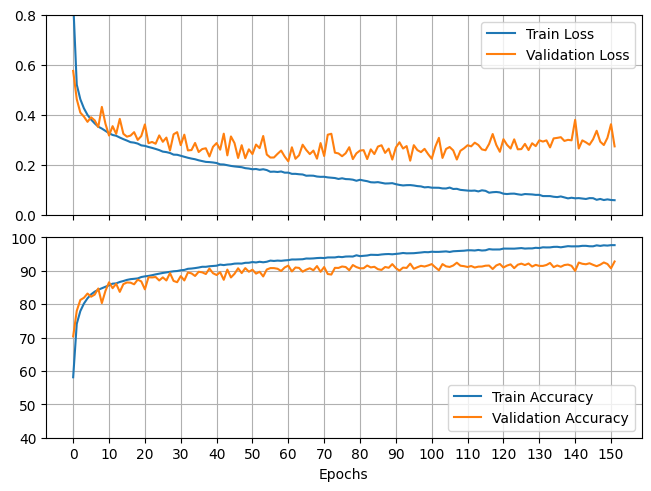

In [47]:
fig, axs = plt.subplots(2, 1,sharex=True)

axs[0].plot(range(len(tr_loss_lst)), tr_loss_lst, label='Train Loss')
axs[0].plot(range(len(val_loss_lst)), val_loss_lst, label='Validation Loss')
axs[0].set_ylim([0, 0.8])

axs[1].plot(range(len(tr_acc_lst)), tr_acc_lst, label='Train Accuracy')
axs[1].plot(range(len(val_acc_lst)), val_acc_lst, label='Validation Accuracy')
axs[1].set_ylim([40, 100])

axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')

axs[0].grid(True)
axs[1].grid(True)

axs[1].set_xlabel('Epochs')

axs[1].set_xticks(np.arange(0, len(val_acc_lst)+1, step=grid_step))

plt.show()

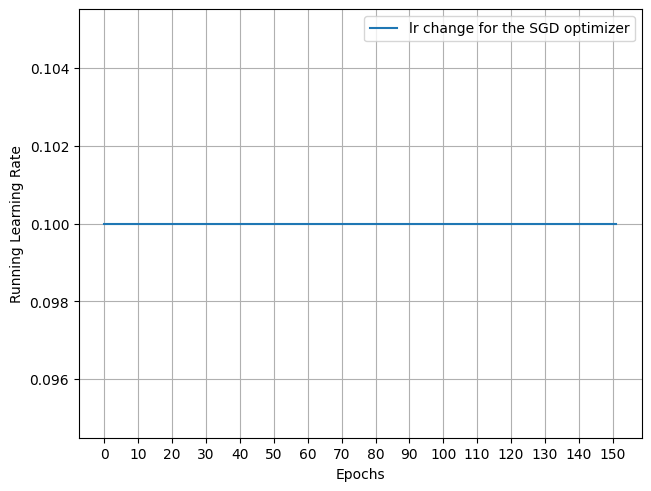

In [48]:
fig, axs = plt.subplots(1, 1)

axs.plot(range(len(running_lr_lst)), running_lr_lst,
         label=f'lr change for the {optimizer_lst[-1]} optimizer')
axs.set_xlabel('Epochs')
axs.set_ylabel('Running Learning Rate')
axs.set_xticks(np.arange(0, len(running_lr_lst)+1, step=grid_step))
axs.grid(True)
axs.legend()
plt.show()

In [49]:
if image_new_size != in_img_size:
    transform_test = transforms.Compose([
        v2.Resize(size=image_new_size),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])
else:
    transform_test = transforms.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
    ])


test_set = Images_Dataset(df_test, transform_test)

test_loader = DataLoader(dataset=test_set,
                         batch_size=test_batch_size,
                         # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                         drop_last=True,
                         shuffle=False,
                         pin_memory=True,
                         num_workers=NUM_WORKERS)

In [50]:
x_test = []
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        x_test.extend(inputs.permute(0, 2, 3, 1).to('cpu').numpy())  # save inputs (ready for plot)
        y_pred.extend(predicted.data.to('cpu').numpy())  # Save Prediction
        y_true.extend(labels.data.to('cpu').numpy())  # Save Truth

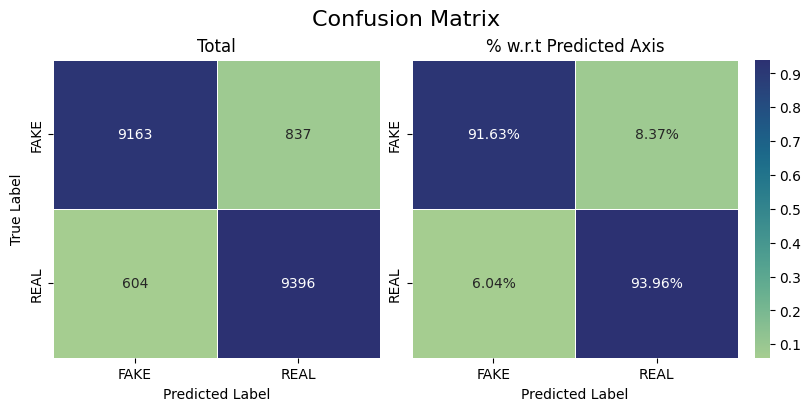

In [51]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
CM_df = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])

CM_recall = cf_matrix / np.sum(cf_matrix, axis=1)[:, None]
# Using [:,None] to slice a numpy row vector will turn it into column vector
CM_recall_df = pd.DataFrame(CM_recall, index=[i for i in classes], columns=[i for i in classes])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

g1 = sn.heatmap(CM_df, annot=True, fmt=".0f", linewidth=.5, cmap="crest", ax=axs[0], cbar=False)
g1.set(xlabel="Predicted Label", ylabel="True Label")
g1.set_title("Total")

g2 = sn.heatmap(CM_recall_df, annot=True, fmt=".2%", linewidth=.5, cmap="crest", ax=axs[1])
g2.set(xlabel="Predicted Label", ylabel="")
g2.set_title("% w.r.t Predicted Axis")
fig.suptitle("Confusion Matrix", fontsize=16)
plt.show()

In [52]:
print(f'Test Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%')
print(f'Test Recall: {recall_score(y_true, y_pred)*100:.2f}%')
print(f'Test f1 Score: {f1_score(y_true, y_pred)*100:.2f}%')

Test Accuracy: 92.80%
Test Recall: 93.96%
Test f1 Score: 92.88%


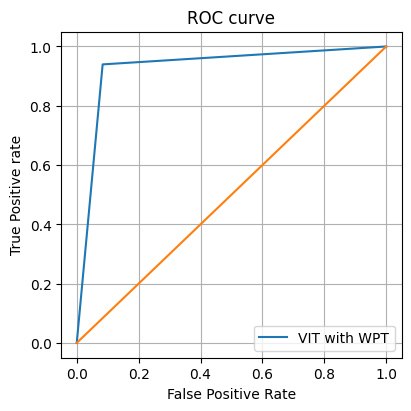

In [53]:
fpr,tpr,threshold=roc_curve(y_true,y_pred)
random_probs = [0 for i in range(len(y_true))]
p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='VIT with WPT')
plt.plot(p_fpr, p_tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

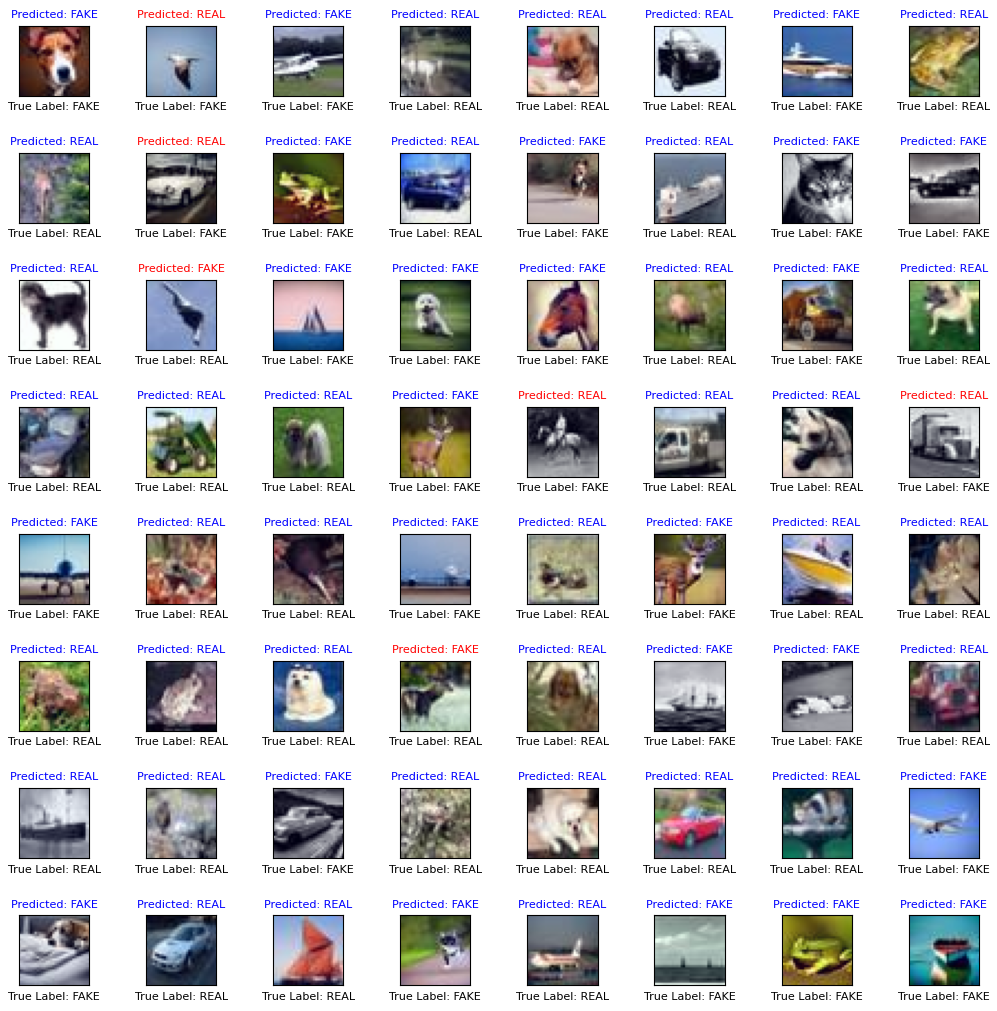

In [54]:
start_idx = 9980
sample_length = 64
cols = 8

test_idxs = range(start_idx, start_idx+sample_length)
rows = -(-sample_length//cols)
# print(rows)

figsize = (cols*1.25, rows*1.25)


margins = {  #inches
    "left":   1.0,
    "bottom": 1.0,
    "right":  1.1,
    "top":    1.1,
    "wspace": 0.2,
    "hspace": 0.2
}

fig, axs = plt.subplots(rows,cols, figsize=figsize, gridspec_kw=margins)

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = test_idxs[i*cols+j]

        tst_img = x_test[idx]
        true_label = classes[y_true[idx]]
        pred_label = classes[y_pred[idx]]
        if pred_label == true_label:
            color = 'b'
        else:
            color = 'r'

        true_label_txt = f'True Label: {true_label}'
        pred_label_txt = f'Predicted: {pred_label}'

        ax.imshow(norm_to_plot(tst_img))
        ax.set_title(pred_label_txt, fontsize=8, color=color)
        ax.set_xlabel(true_label_txt, fontsize=8)
        ax.set(xticks=[], yticks=[])
plt.show()

In [55]:
sample_test_imgt_bch, sample_test_label_bch = next(iter(test_loader))

In [56]:
# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [57]:
h=model.transformer.layers[0][0].fn.softmax.register_forward_hook(getActivation('weights'))

test_output = model(sample_test_imgt_bch.to(device))

In [58]:
def plot_attention(attention_matrix, title, wpt_dim, step):
    fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    hm = sn.heatmap(attention_matrix,
                    ax=ax,
                    cmap='Greens',
                    square=True,
                    cbar_kws={'shrink': 0.6})

    # Drawing the frame
    for _, spine in hm.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color("k")

    fig.suptitle(f"Attention of a {title} Image", fontsize=16)

    all_patches = attention_matrix.shape[-1]

    ticks_line1 = np.arange(0, all_patches+1, step=1)
    ticks_line2 = np.arange(0, all_patches+1, step=step)

    ax.set_yticks(ticks_line1)
    ax.set_xticks(ticks_line1)

    ax.xaxis.set_minor_locator(ticker.FixedLocator(ticks_line1))
    ax.yaxis.set_minor_locator(ticker.FixedLocator(ticks_line1))
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_line2))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ticks_line2))

    ax.set_xticklabels(ticks_line2//patches_per_dec, rotation=0, fontsize=7)
    ax.set_yticklabels(ticks_line2//patches_per_dec, rotation=0, fontsize=7)

    ax.xaxis.set_ticks_position('top')
    ax.grid(True, which='major', color='k')
    ax.grid(True, which='minor', color='darkgray')
    # ax.minorticks_on()

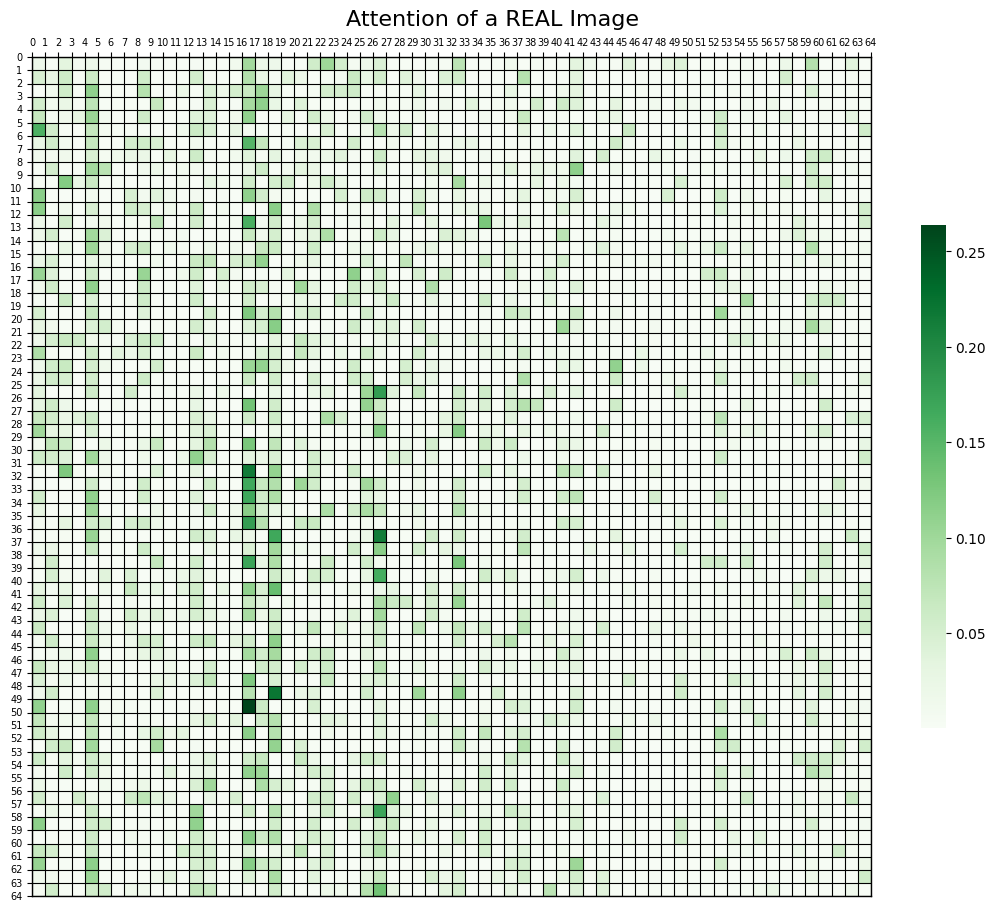

In [59]:
index = 0
mat1 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title1 = classes[sample_test_label_bch[index]]
plot_attention(mat1, title1, wpt_img_size, patches_per_dec)

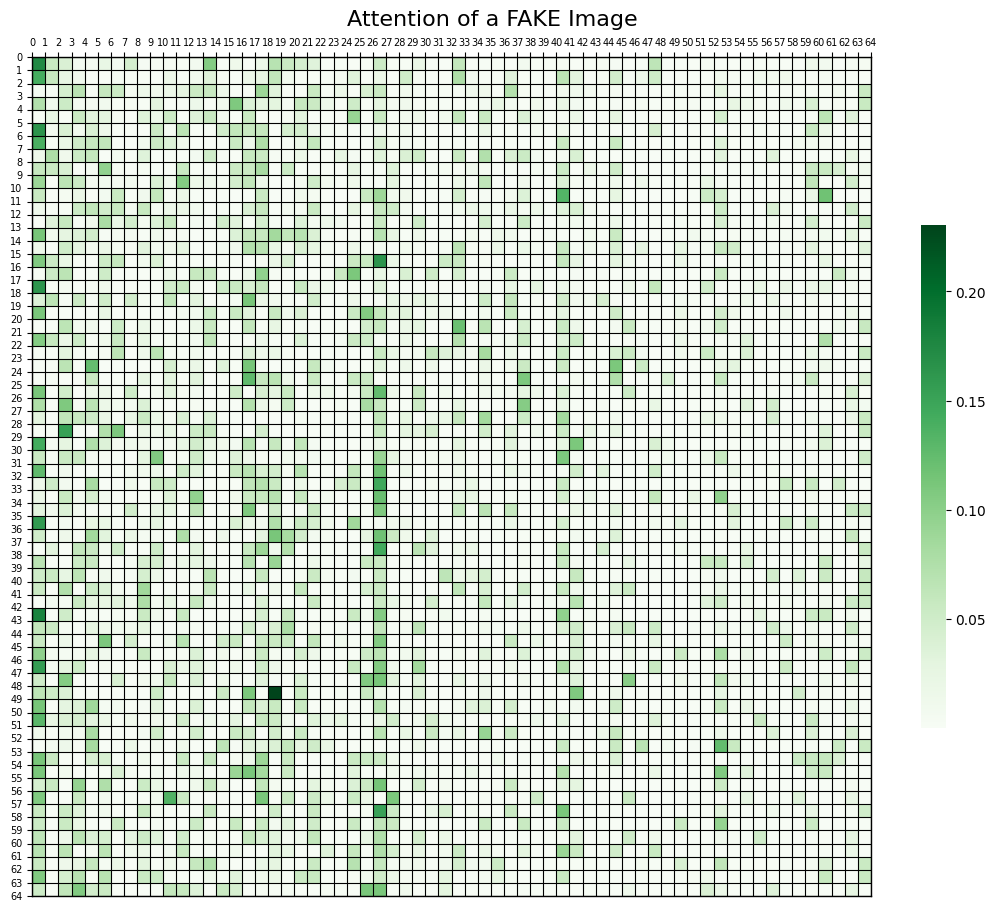

In [60]:
index = 900
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title2 = classes[sample_test_label_bch[index]]
plot_attention(mat2, title2, wpt_img_size,  patches_per_dec)

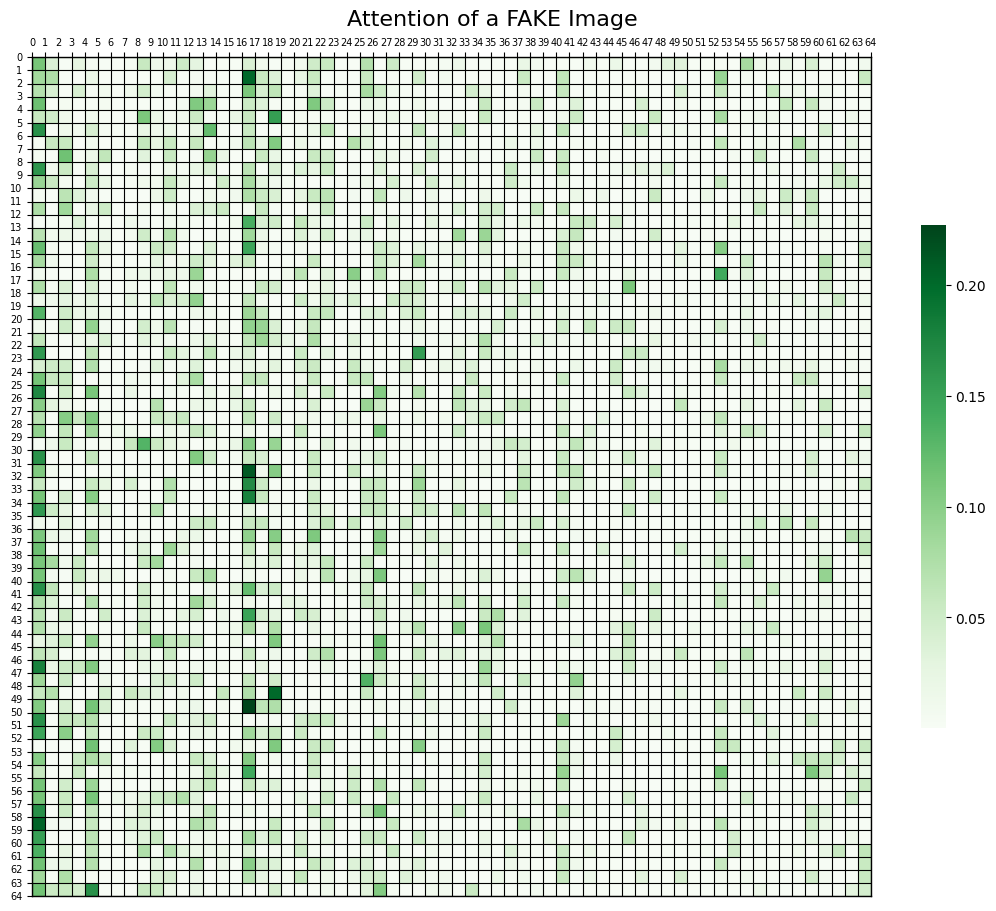

In [61]:
index = 660
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title2 = classes[sample_test_label_bch[index]]
plot_attention(mat2, title2, wpt_img_size,  patches_per_dec)

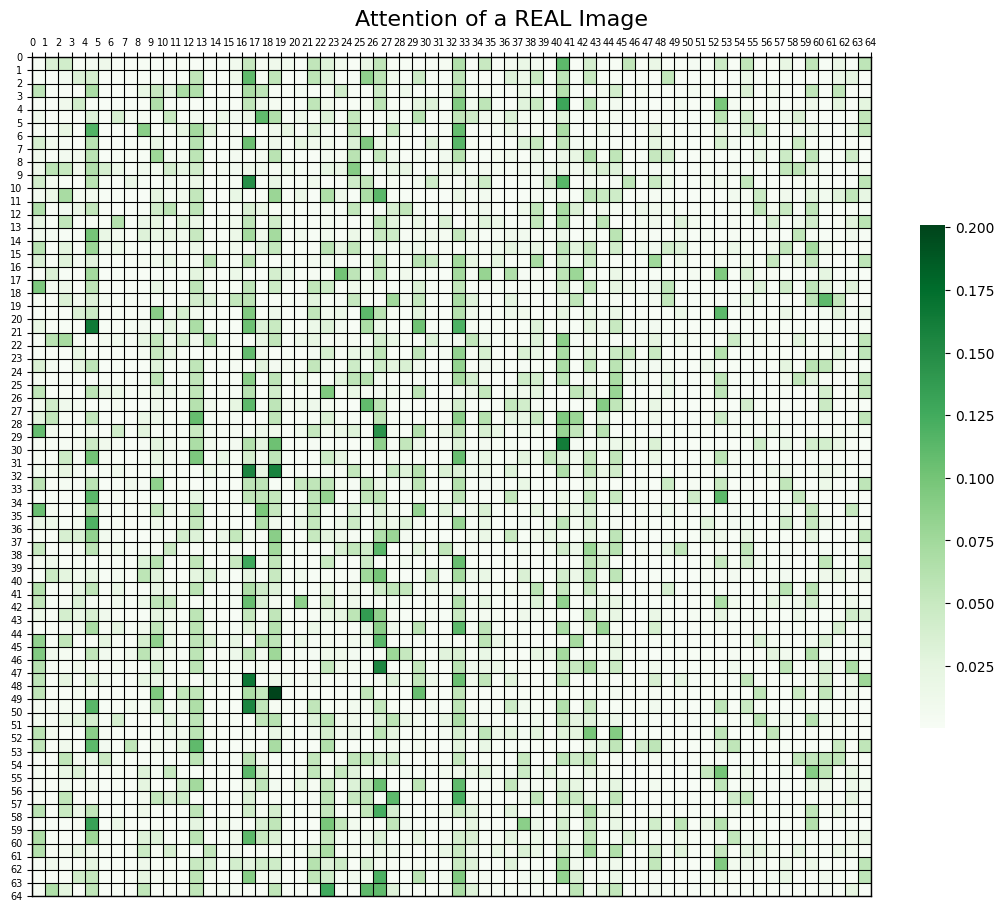

In [62]:
index = 20
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()
title2 = classes[sample_test_label_bch[index]]
plot_attention(mat2, title2, wpt_img_size,  patches_per_dec)

In [63]:
# I'm using 16 heads , while the original embedding size of flattened patches is 16 RGB pixels
# hence each head will compute the attention of a single RGB pixel
# every minor tick represent an image patch, and every major tick represents 
# one of the WPT decompositions of a sample test image. 
# By taking mean of the 16 heads attentions, we measure the attention between each patch and
# all of its spatial neighbors, at the same time we measure attention with patches from other 
# wavelet decompositions.
# Result shows that a high attention could be found between patches from different WPT decompositions.

